<a href="https://colab.research.google.com/github/helloarun0110/Deep-Learning/blob/main/CNN/build_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Build Convolutional Neural Network**


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

**Define the CNN Architecture**

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # 32x32x3 -> 32x32x32
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 32x32x32 -> 16x16x32

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 16x16x32 -> 16x16x64
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16x64 -> 8x8x64

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 8x8x64 -> 8x8x128
    self.bn3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 8x8x128 -> 4x4x128

    self.fc1 = nn.Linear(in_features = 128*4*4, out_features=265)
    self.fc2 = nn.Linear(in_features = 265, out_features=128)
    self.fc3 = nn.Linear(in_features = 128, out_features=10)

    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.pool1(F.relu(self.bn1(self.conv1(x))))

    x = self.pool2(F.relu(self.bn2(self.conv2(x))))

    x = self.pool3(F.relu(self.bn3(self.conv3(x))))

    x = x.view(-1, 128*4*4)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)

    x = F.relu((self.fc2(x)))
    x = self.dropout(x)

    x = self.fc3(x)
    return x




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [ ]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 265]         542,985
          Dropout-11                  [-1, 265]               0
           Linear-12                  [-1, 128]          34,048
          Dropout-13                  [-1, 128]               0
           Linear-14                   

**CIRAR10 Image Dataset and its Augmentation**

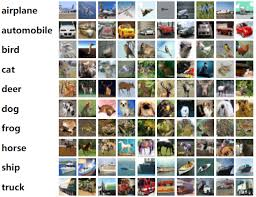

In [ ]:
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(train_dataset))
print(len(test_dataset))

100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
50000
10000


**HyperParameters Optimazation**

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

**CNN Training**

In [ ]:
for epoch in range(10):
  train_loss = 0.0
  train_correct = 0
  model.train()
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    _, predicted = torch.max(output.data, 1)
    train_correct += (predicted == target).sum().item()

  train_loss /= len(train_loader.dataset)
  train_acc = 100. * train_correct / len(train_loader.dataset)
  print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

  scheduler.step()

Epoch 1: Train Loss: 0.0271, Train Acc: 35.67%
Epoch 2: Train Loss: 0.0225, Train Acc: 47.84%
Epoch 3: Train Loss: 0.0206, Train Acc: 53.21%
Epoch 4: Train Loss: 0.0192, Train Acc: 57.35%
Epoch 5: Train Loss: 0.0182, Train Acc: 59.60%
Epoch 6: Train Loss: 0.0174, Train Acc: 61.64%
Epoch 7: Train Loss: 0.0167, Train Acc: 63.39%
Epoch 8: Train Loss: 0.0152, Train Acc: 66.89%
Epoch 9: Train Loss: 0.0147, Train Acc: 67.98%
Epoch 10: Train Loss: 0.0145, Train Acc: 68.50%


**CNN Testing**

In [ ]:
with torch.no_grad():
  test_loss = 0.0
  test_correct = 0
  all_labels = []
  all_preds = []
  model.eval()
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    _, predicted = torch.max(output.data, 1)
    test_correct += (predicted == target).sum().item()

    all_labels.extend(target.cpu().numpy())
    all_preds.extend(predicted.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_acc = 100. * test_correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')



Test Loss: 0.0128, Test Acc: 72.36%


**Output Visualization**

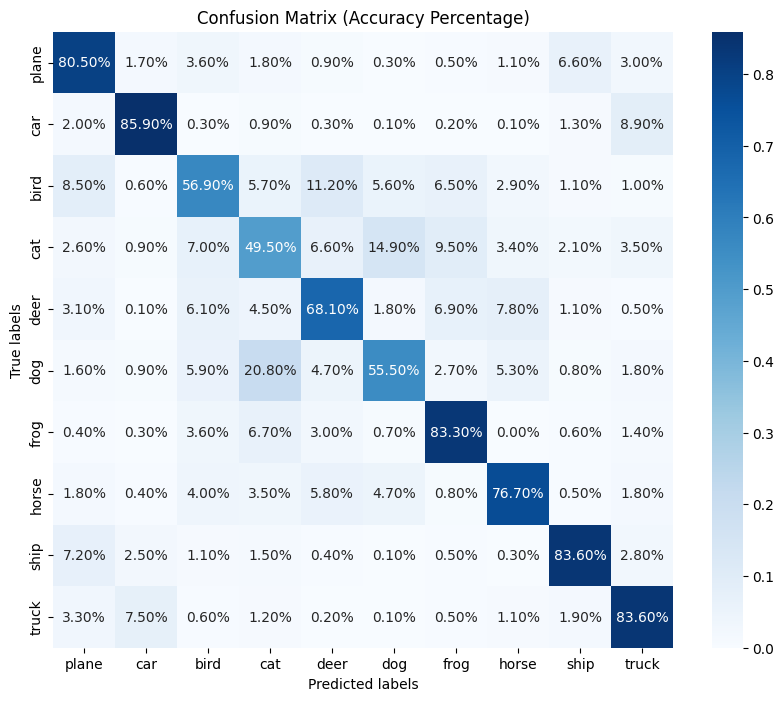

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(all_labels, all_preds)

conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2%', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Accuracy Percentage)')
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

       plane       0.73      0.81      0.76      1000
         car       0.85      0.86      0.86      1000
        bird       0.64      0.57      0.60      1000
         cat       0.52      0.49      0.50      1000
        deer       0.67      0.68      0.68      1000
         dog       0.66      0.56      0.60      1000
        frog       0.75      0.83      0.79      1000
       horse       0.78      0.77      0.77      1000
        ship       0.84      0.84      0.84      1000
       truck       0.77      0.84      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

